In [35]:
import gzip
import glob
import csv
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

#Système étudié :
PMF='./popc/pmfs/'
bil_exp='./hydrophobicity/bilayer_wat_data.dat'
oct_exp='./hydrophobicity/oct_wat_data.dat'
chx_exp='./hydrophobicity/chx_wat_data.dat'
dlpc_exp='./hydrophobicity/wat_dlpc_data.dat'

In [36]:
#Fonctions
def free_energy(pKa, charge):
    R=8.314*10**(-3) #kJ/mol.K
    T=302.3545798089109 #K
    pH=7.0
    return -charge*R*T*np.log(10)*(pKa-pH)

def get_ref_per_acid(acid):
    #https://www.vanderbilt.edu/AnS/Chemistry/Rizzo/stuff/AA/AminoAcids.html
    # Pour la ref aux residus chargés
    #neutrals=['SCHE', 'SCHD', 'SCKN', 'SCRN', 'SCDN', 'SCEN', 'SCC']
    #pKas=[6.04, 6.04, 10.54, 12.48, 3.90, 4.07, 8.37]
    #charges=[1, 1, 1, 1, -1, -1, -1]
    # Pour la ref aux résidus non-chargés
    neutrals=['SCHP', 'SCKN', 'SCRN', 'SCDN', 'SCEN', 'SCCM', 'SCYM']
    pKas=[6.04, 10.54, 12.48, 3.90, 4.07, 8.37, 10.46]
    charges=[1, -1, -1, 1, 1, -1, -1]
    #zero=dfref['density{}{}'.format(traj, i)].values[55]+e #if per traj
    if acid in neutrals:
        zero_ref=free_energy(pKas[neutrals.index(acid)], charges[neutrals.index(acid)])
    else:
        zero_ref=0
    return zero_ref

def PMF_residue(acid):
    dfpmf=pd.read_table(PMF+f'{acid}.dat'.lower(), sep="\s+")
    return dfpmf

def coeff_corr(x_coor, y_coor):
    #formula: r=sum((x_i-x)*(y_i-y))/sqrt(sum((x_i-x)**2*(y_i-y)**2))
    #mean calculation
    x=np.average(x_coor)
    y=np.average(y_coor)
    #nominator calculation
    N=np.sum((x_coor-x)*(y_coor-y))
    #demoninator calculation
    D=np.sqrt(np.sum((x_coor-x)**2)*np.sum((y_coor-y)**2))
    r=N/D
    return r

def least_square(X, Y):
    # Mean X and Y
    mean_x = np.mean(X)
    mean_y = np.mean(Y)
    # Total number of values
    n = len(X)
    # Using the formula to calculate m and c
    numer = 0
    denom = 0
    for i in range(n):
        numer += (X[i] - mean_x) * (Y[i] - mean_y)
        denom += (X[i] - mean_x) ** 2
    m = numer / denom
    c = mean_y - (m * mean_x)
    # Cannot use Rank 1 matrix in scikit learn
    X = X.reshape((m, 1))
    # Creating Model
    reg = LinearRegression()
    # Fitting training data
    reg = reg.fit(X, Y)
    # Y Prediction
    Y_pred = reg.predict(X)
    # Calculating R2 Score
    r2_score = reg.score(X, Y)
    return r2_score

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

def plot_regression(x, y):
    """
    Trace la courbe de régression pour les points (x, y) et affiche le coefficient de corrélation.

    :param x: Liste ou tableau numpy contenant les valeurs x.
    :param y: Liste ou tableau numpy contenant les valeurs y.
    """
    # Vérification que les tailles de x et y correspondent
    if len(x) != len(y):
        raise ValueError("Les tailles des listes x et y doivent être identiques.")

    # Calcul de la régression linéaire
    slope, intercept, r_value, p_value, std_err = linregress(x, y)

    # Calcul des valeurs prédites pour la ligne de régression
    y_pred = slope * np.array(x) + intercept

    # Affichage des résultats
    print(f"Équation de la droite : y = {slope:.3f}x + {intercept:.3f}")
    print(f"Coefficient de corrélation (R) : {r_value:.3f}")
    print(f"Coefficient de détermination (R²) : {r_value**2:.3f}")
    return x, y_pred
    

In [38]:
aa_name=['GLYD', 'SCA', 'SCV', 'SCL', 'SCI', 'SCP', 'SCHD', 'SCHE', 'SCHP', 'SCW',
         'SCY', 'SCM', 'SCC', 'SCCM', 'SCF', 'SCS', 'SCT', 'SCK', 'SCKN', 'SCR',
         'SCRN', 'SCE', 'SCEN', 'SCD', 'SCDN','SCQ', 'SCN']

aa_symbol=['GLY', 'ALA', 'VAL', 'LEU', 'ILE', 'PRO', 'HSD', 'HSE', 'HSP', 'TRP',
           'TYR', 'MET', 'CYS', 'CYSM', 'PHE', 'SER', 'THR', 'LYS', 'LYSN', 'ARG',
           'ARGN', 'GLU', 'GLUN', 'ASP','ASPN','GLN', 'ASN']
#print PMF of interface (z=20.5)
df_pmf=pd.DataFrame(columns=['#resid', 'PMF_i', 'std_err_pmf_i', 'PMF_c', 'std_err_pmf_c'])

for i in range(len(aa_name)):
    acid=aa_name[i]
    temp= PMF_residue(acid)
    #display(temp)
    sym=aa_symbol[i]
    # interface = 21.5 A du centre de la bicouche
    # ce choix permet de tenir compte de la densité maximale (19.5 A)
    # et apporte la contribution des cholines
    int=20
    cen=0
    if i==0:
        print('bilayer interface :', temp.iloc[int]['x'], 'angstrom')
        print('bilayer center :', temp.iloc[cen]['x'], 'angstrom')
    pmfi=temp.iloc[int]['PMF_mean']
    stdi=temp.iloc[int]['std_error']
    pmfc=temp.iloc[cen]['PMF_mean']
    stdc=temp.iloc[cen]['std_error']
    df_pmf.loc[len(df_pmf.index)] = [sym, pmfi, stdi, pmfc, stdc]
#display(df_pmf)

bilayer interface : 20.5 angstrom
bilayer center : 0.5 angstrom


coefficient de correlation 0.8775964471182043
Équation de la droite : y = 1.408x + 4.702
Coefficient de corrélation (R) : 0.878
Coefficient de détermination (R²) : 0.770


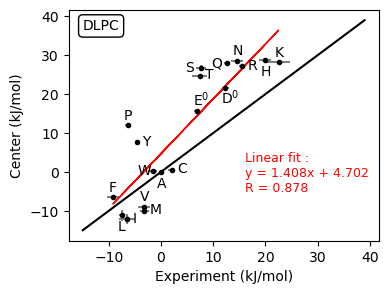

In [39]:
#prendre info des datas experimentales : BILAYER
df=pd.read_table(dlpc_exp, sep="\s+", skiprows=[0])

#1 kcal/mol = 4.184 kJ/mol
k=4.184
df['OmpLA'] = df['OmpLA'].multiply(k)
df['std_err'] = df['std_err'].multiply(abs(k))
#display(df)

#plot
plt.figure(figsize=(4,3))
#compare df_pmf and df
aa_list1=['ALA', 'VAL', 'LEU', 'ILE', 'PRO', 'HIS', 'TRP',
           'TYR', 'MET', 'CYS', 'PHE', 'SER', 'THR', 'LYS',
           'ARG', 'GLU','ASP','GLN', 'ASN']
aa_list2=['ALA', 'VAL', 'LEU', 'ILE', 'PRO', 'HSE', 'TRP',
           'TYR', 'MET', 'CYS', 'PHE', 'SER', 'THR', 'LYS',
           'ARG', 'GLUN','ASPN','GLN', 'ASN']
aa_letter=['A', 'V', 'L', 'I', 'P', 'H', 'W',
           'Y', 'M', 'C', 'F', 'S', 'T', 'K',
           'R', 'E$^0$','D$^0$','Q', 'N']
#take pH=8

df_comp=pd.DataFrame(columns=['#resid', 'G_exp', 'PMF'])
x_coor, y_coor = [], []
for i in range(len(aa_list1)):
    name1=aa_list1[i]
    name2=aa_list2[i]
    if i==0:
        ref=aa_list1[i]
        df1=df[df['pH']<=7]
        df2=df1[df1['#resid']==name1]
        DG_ref=df2.iloc[0]['OmpLA']
        df2_pmf=df_pmf[df_pmf['#resid']==name2]
        PMF_ref=df2_pmf.iloc[0]['PMF_c']
    df1=df[df['pH']<=7]
    df2=df1[df1['#resid']==name1]
    DG=df2.iloc[0]['OmpLA']-DG_ref
    df2_pmf=df_pmf[df_pmf['#resid']==name2]
    PMF=df2_pmf.iloc[0]['PMF_c']-PMF_ref
    df_comp.loc[len(df_comp.index)] = [name2, DG, PMF]
    x_err, y_err=df2.iloc[0]['std_err'], df2_pmf.iloc[0]['std_err_pmf_c']
    x_coor.append(DG)
    y_coor.append(PMF)
    plt.errorbar(DG, PMF, xerr=x_err, yerr=y_err, label=name2, color='k', fmt='.', ecolor='grey')
    if aa_letter[i] in ['S', 'W', 'Q']:
        plt.text(DG-3, PMF-1, aa_letter[i]) #left
    elif aa_letter[i] in ['I', 'M', 'R', 'C', 'Y', 'T']:
        plt.text(DG+1, PMF-0.8, aa_letter[i]) #right
    elif aa_letter[i] in ['P', 'E$^0$', 'F', 'K', 'N', 'V']:
        plt.text(DG-0.8, PMF+1.5, aa_letter[i]) #top
    elif aa_letter[i] in ['A', 'H', 'L', 'D$^0$']:
        plt.text(DG-0.8, PMF-4, aa_letter[i]) #bottom
    else:
        plt.text(DG, PMF, aa_letter[i]) #unknown
    
print('coefficient de correlation', coeff_corr(x_coor, y_coor))
#print('least square', least_square(x_coor, y_coor))
plt.text(-15, 36.5, 'DLPC', bbox=dict(facecolor='none', edgecolor='black', boxstyle='round,pad=0.3'))
#plt.text(16, -8, 'correlation coeff. : \n'+format(coeff_corr(x_coor, y_coor), ".3f"), fontsize=8)
x=range(-15,40)
plt.errorbar(x, x, color='k')
plt.xlabel('Experiment (kJ/mol)')
plt.ylabel('Center (kJ/mol)')
#plt.legend()
#display(df_comp)
x, y_pred = plot_regression(x_coor, y_coor)
plt.plot(x, y_pred, color='r', linewidth=1)
plt.text(16, -5, 'Linear fit :\n'+'y = 1.408x + 4.702\n'+'R = 0.878', fontsize=9, color='red')
plt.savefig('bilayer_v_center_pH4.png', bbox_inches='tight') #, transparent=True)
plt.show()


coefficient de correlation 0.8668779721468322
Équation de la droite : y = 0.913x + -1.801
Coefficient de corrélation (R) : 0.867
Coefficient de détermination (R²) : 0.751


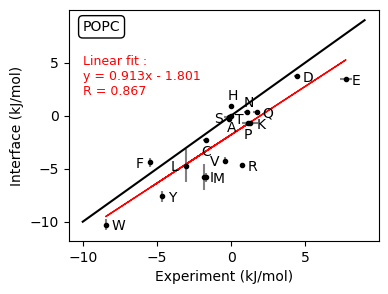

In [31]:
#prendre info des datas experimentales : BILAYER
df=pd.read_table(bil_exp, sep="\s+", skiprows=[0])

#1 kcal/mol = 4.184 kJ/mol
k=-4.184
df['DeltaG_WLXLL'] = df['DeltaG_WLXLL'].multiply(k)
df['std_err_G'] = df['std_err_G'].multiply(abs(k))
#display(df)

#plot
plt.figure(figsize=(4,3))
#compare df_pmf and df
aa_list1=['ALA', 'VAL', 'LEU', 'ILE', 'PRO', 'HIS', 'TRP',
           'TYR', 'MET', 'CYS', 'PHE', 'SER', 'THR', 'LYS',
           'ARG', 'GLU','ASP','GLN', 'ASN']
aa_list2=['ALA', 'VAL', 'LEU', 'ILE', 'PRO', 'HSE', 'TRP',
           'TYR', 'MET', 'CYS', 'PHE', 'SER', 'THR', 'LYS',
           'ARG', 'GLU','ASP','GLN', 'ASN']
aa_letter=['A', 'V', 'L', 'I', 'P', 'H', 'W',
           'Y', 'M', 'C', 'F', 'S', 'T', 'K',
           'R', 'E','D','Q', 'N']
#take pH=8

df_comp=pd.DataFrame(columns=['#resid', 'G_exp', 'PMF'])
x_coor, y_coor = [], []
for i in range(len(aa_list1)):
    name1=aa_list1[i]
    name2=aa_list2[i]
    if i==0:
        ref=aa_list1[i]
        df1=df[df['pH']>=7]
        df2=df1[df1['#resid']==name1]
        DG_ref=df2.iloc[0]['DeltaG_WLXLL']
        df2_pmf=df_pmf[df_pmf['#resid']==name2]
        PMF_ref=df2_pmf.iloc[0]['PMF_i']
    df1=df[df['pH']>=7]
    df2=df1[df1['#resid']==name1]
    DG=df2.iloc[0]['DeltaG_WLXLL']-DG_ref
    df2_pmf=df_pmf[df_pmf['#resid']==name2]
    PMF=df2_pmf.iloc[0]['PMF_i']-PMF_ref
    df_comp.loc[len(df_comp.index)] = [name2, DG, PMF]
    x_err, y_err=df2.iloc[0]['std_err_G'], df2_pmf.iloc[0]['std_err_pmf_i']
    x_coor.append(DG)
    y_coor.append(PMF)
    plt.errorbar(DG, PMF, xerr=x_err, yerr=y_err, label=name2, color='k', fmt='.', ecolor='grey')
    if aa_letter[i] in ['F', 'S', 'V', 'L']:
        plt.text(DG-1, PMF-0.5, aa_letter[i]) #left
    elif aa_letter[i] in ['I', 'R', 'D', 'E', 'Q', 'T', 'W', 'K', 'M', 'Y']:
        plt.text(DG+0.4, PMF-0.5, aa_letter[i]) #right
    elif aa_letter[i] in ['H', 'N']:
        plt.text(DG-0.2, PMF+0.5, aa_letter[i]) #top
    elif aa_letter[i] in ['A', 'P', 'C']:
        plt.text(DG-0.3, PMF-1.5, aa_letter[i]) #bottom
    else:
        plt.text(DG, PMF, aa_letter[i]) #unknown
    
    
print('coefficient de correlation', coeff_corr(x_coor, y_coor))
#print('least square', least_square(x_coor, y_coor))
plt.text(-10, 8, 'POPC', bbox=dict(facecolor='none', edgecolor='black', boxstyle='round,pad=0.3'))
#plt.text(2, -10, 'correlation\n coeff. : '+format(coeff_corr(x_coor, y_coor), ".2f"))
x=range(-10,10)
plt.errorbar(x, x, color='k')
plt.xlabel('Experiment (kJ/mol)')
plt.ylabel('Interface (kJ/mol)')
#plt.legend()
#display(df_comp)
x, y_pred = plot_regression(x_coor, y_coor)
plt.plot(x, y_pred, color='r', linewidth=1)
plt.text(-10, 2, 'Linear fit :\n'+'y = 0.913x - 1.801\n'+'R = 0.867', fontsize=9, color='red')
plt.savefig('bilayer_v_interface_pH8.png', bbox_inches='tight') #, transparent=True)
plt.show()


coefficient de correlation 0.83279927720303


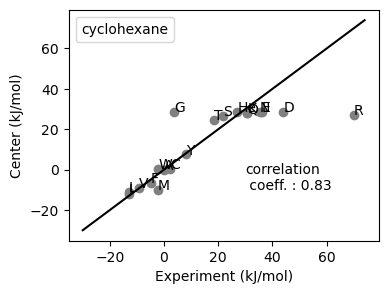

In [ ]:
#prendre info des datas experimentales
df=pd.read_table(chx_exp, sep="\s+", skiprows=[0])

#1 kcal/mol = 4.184 kJ/mol
k=-4.184
df['DeltaG_WLXLL'] = df['DeltaG_WLXLL'].multiply(k)
#df['std_err_G'] = df['std_err_G'].multiply(k)
#display(df)

#plot
plt.figure(figsize=(4,3))
#compare df_pmf and df
aa_list1=['ALA', 'GLY', 'VAL', 'LEU', 'ILE', 'HIS', 'TRP',
           'TYR', 'MET', 'CYS', 'PHE', 'SER', 'THR', 'LYS',
           'ARG', 'GLU','ASP','GLN', 'ASN']
aa_list2=['ALA', 'GLY', 'VAL', 'LEU', 'ILE', 'HSE', 'TRP',
           'TYR', 'MET', 'CYS', 'PHE', 'SER', 'THR', 'LYS',
           'ARG', 'GLU','ASP','GLN', 'ASN']
aa_letter=['A', 'G', 'V', 'L', 'I', 'He', 'W',
           'Y', 'M', 'C', 'F', 'S', 'T', 'K',
           'R', 'E','D','Q', 'N']
#take pH=8
df1=df[df['pH']>=7]

df_comp=pd.DataFrame(columns=['#resid', 'G_exp', 'PMF'])
x_coor, y_coor = [], []
for i in range(len(aa_list1)):
    name1=aa_list1[i]
    name2=aa_list2[i]
    if i==0:
        ref=aa_list1[i]
        df1=df[df['pH']>=7]
        df2=df1[df1['#resid']==name1]
        DG_ref=df2.iloc[0]['DeltaG_WLXLL']
        df2_pmf=df_pmf[df_pmf['#resid']==name2]
        PMF_ref=df2_pmf.iloc[0]['PMF_c']
    df1=df[df['pH']>=7]
    df2=df1[df1['#resid']==name1]
    DG=df2.iloc[0]['DeltaG_WLXLL']-DG_ref
    df2_pmf=df_pmf[df_pmf['#resid']==name2]
    PMF=df2_pmf.iloc[0]['PMF_c']-PMF_ref
    df_comp.loc[len(df_comp.index)] = [name2, DG, PMF]
    x_coor.append(DG)
    y_coor.append(PMF)
    plt.scatter(DG, PMF, label=name2, color='grey', marker='o')
    plt.text(DG, PMF, aa_letter[i])
print('coefficient de correlation', coeff_corr(x_coor, y_coor))
#print('least square', least_square(x_coor, y_coor))
plt.legend(['cyclohexane'], loc='upper left', markerscale=0, handletextpad=-2.0)
plt.text(30, -10, 'correlation\n coeff. : '+format(coeff_corr(x_coor, y_coor), ".2f"))
x=range(-30,75)
plt.plot(x, x, color='k')
plt.xlabel('Experiment (kJ/mol)')
plt.ylabel('Center (kJ/mol)')
#plt.legend()
#display(df_comp)
#plt.savefig('chx_v_center.png', bbox_inches='tight') #, transparent=True)
plt.show()


coefficient de correlation 0.7868140575610342


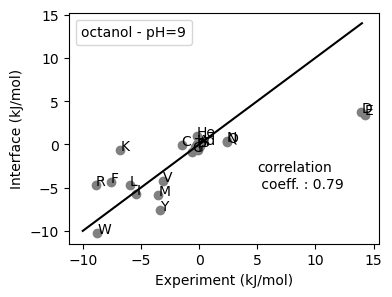

In [ ]:
#prendre info des datas experimentales
df=pd.read_table(oct_exp, sep="\s+", skiprows=[0])

#1 kcal/mol = 4.184 kJ/mol
k=-4.184
df['DeltaG_WLXLL'] = df['DeltaG_WLXLL'].multiply(k)
df['std_err_G'] = df['std_err_G'].multiply(k)
#display(df)

#plot
plt.figure(figsize=(4,3))
#compare df_pmf and df
aa_list1=['ALA', 'GLY', 'VAL', 'LEU', 'ILE', 'PRO', 'HIS', 'HIS', 'TRP',
           'TYR', 'MET', 'CYS', 'PHE', 'SER', 'THR', 'LYS',
           'ARG', 'GLU','ASP','GLN', 'ASN']
aa_list2=['ALA', 'GLY', 'VAL', 'LEU', 'ILE', 'PRO', 'HSE', 'HSD', 'TRP',
           'TYR', 'MET', 'CYSM', 'PHE', 'SER', 'THR', 'LYS',
           'ARG', 'GLU','ASP','GLN', 'ASN']
aa_letter=['A', 'G', 'V', 'L', 'I', 'P', 'He', 'Hd', 'W',
           'Y', 'M', 'C', 'F', 'S', 'T', 'K',
           'R', 'E','D','Q', 'N']
#take pH=8

df_comp=pd.DataFrame(columns=['#resid', 'G_exp', 'PMF'])
x_coor, y_coor = [], []
for i in range(len(aa_list1)):
    name1=aa_list1[i]
    name2=aa_list2[i]
    if i==0:
        ref=aa_list1[i]
        df1=df[df['pH']>=7]
        df2=df1[df1['#resid']==name1]
        DG_ref=df2.iloc[0]['DeltaG_WLXLL']
        df2_pmf=df_pmf[df_pmf['#resid']==name2]
        PMF_ref=df2_pmf.iloc[0]['PMF_i']
    df1=df[df['pH']>=7]
    df2=df1[df1['#resid']==name1]
    DG=df2.iloc[0]['DeltaG_WLXLL']-DG_ref
    df2_pmf=df_pmf[df_pmf['#resid']==name2]
    PMF=df2_pmf.iloc[0]['PMF_i']-PMF_ref
    df_comp.loc[len(df_comp.index)] = [name2, DG, PMF]
    x_coor.append(DG)
    y_coor.append(PMF)
    plt.scatter(DG, PMF, label=name2, color='grey', marker='o')
    plt.text(DG, PMF, aa_letter[i])
print('coefficient de correlation', coeff_corr(x_coor, y_coor))
#print('least square', least_square(x_coor, y_coor))
plt.legend(['octanol - pH=9'], loc='upper left', markerscale=0, handletextpad=-2.0)
plt.text(5, -5, 'correlation\n coeff. : '+format(coeff_corr(x_coor, y_coor), ".2f"))
x=range(-10,15)
plt.plot(x, x, color='k')
plt.xlabel('Experiment (kJ/mol)')
plt.ylabel('Interface (kJ/mol)')
#plt.legend()
#display(df_comp)
#plt.savefig('oct_v_interface_pH9.png', bbox_inches='tight') #, transparent=True)
plt.show()


coefficient de correlation 0.06047996979698849


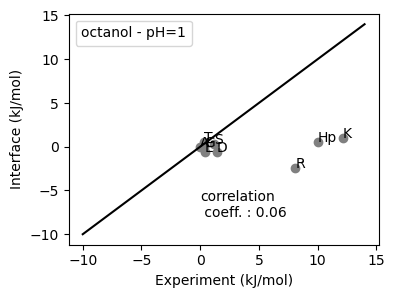

In [ ]:
#prendre info des datas experimentales
df=pd.read_table(oct_exp, sep="\s+", skiprows=[0])

#1 kcal/mol = 4.184 kJ/mol
k=-4.184
df['DeltaG_WLXLL'] = df['DeltaG_WLXLL'].multiply(k)
df['std_err_G'] = df['std_err_G'].multiply(k)
#display(df)

#plot
plt.figure(figsize=(4,3))
#compare df_pmf and df
aa_prot1=['ALA', 'ARG', 'ASP', 'GLU', 'GLY', 'HIS', 'LYS', 'SER', 'THR']
aa_prot2=['ALA', 'ARG', 'ASPN', 'GLUN', 'GLY', 'HSP', 'LYS', 'SER', 'THR']
aa_protter=['A', 'R', 'D', 'E', 'G', 'Hp', 'K', 'S', 'T']
#take pH=8

df_comp=pd.DataFrame(columns=['#resid', 'G_exp', 'PMF'])
x_coor, y_coor = [], []
for i in range(len(aa_prot1)):
    name1=aa_prot1[i]
    name2=aa_prot2[i]
    if i==0:
        ref=aa_list1[i]
        df1=df[df['pH']<=7]
        df2=df1[df1['#resid']==name1]
        DG_ref=df2.iloc[0]['DeltaG_WLXLL']
        df2_pmf=df_pmf[df_pmf['#resid']==name2]
        PMF_ref=df2_pmf.iloc[0]['PMF_i']
    df1=df[df['pH']<=7]
    df2=df1[df1['#resid']==name1]
    DG=df2.iloc[0]['DeltaG_WLXLL']-DG_ref
    df2_pmf=df_pmf[df_pmf['#resid']==name2]
    PMF=df2_pmf.iloc[0]['PMF_i']-PMF_ref
    df_comp.loc[len(df_comp.index)] = [name2, DG, PMF]
    x_coor.append(DG)
    y_coor.append(PMF)
    plt.scatter(DG, PMF, label=name2, color='grey', marker='o')
    plt.text(DG, PMF, aa_protter[i])
print('coefficient de correlation', coeff_corr(x_coor, y_coor))
#print('least square', least_square(x_coor, y_coor))
plt.legend(['octanol - pH=1'], loc='upper left', markerscale=0, handletextpad=-2.0)
plt.text(0, -8, 'correlation\n coeff. : '+format(coeff_corr(x_coor, y_coor), ".2f"))
x=range(-10,15)
plt.plot(x, x, color='k')
plt.xlabel('Experiment (kJ/mol)')
plt.ylabel('Interface (kJ/mol)')
#plt.legend()
#display(df_comp)
#plt.savefig('oct_v_interface_pH1.png', bbox_inches='tight') #, transparent=True)
plt.show()


coefficient de correlation 0.05145462095682314


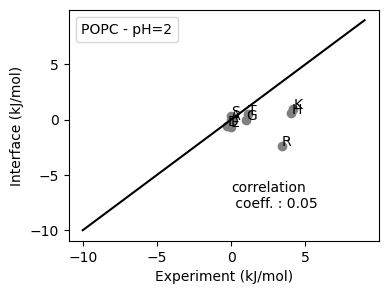

In [ ]:
#prendre info des datas experimentales : BILAYER
df=pd.read_table(bil_exp, sep="\s+", skiprows=[0])

#1 kcal/mol = 4.184 kJ/mol
k=-4.184
df['DeltaG_WLXLL'] = df['DeltaG_WLXLL'].multiply(k)
df['std_err_G'] = df['std_err_G'].multiply(k)
#display(df)

#plot
plt.figure(figsize=(4,3))
#compare df_pmf and df

aa_prot1=['ALA', 'ARG', 'ASP', 'GLU', 'GLY', 'HIS', 'LYS', 'SER', 'THR']
aa_prot2=['ALA', 'ARG', 'ASPN', 'GLUN', 'GLY', 'HSP', 'LYS', 'SER', 'THR']
aa_protter=['A', 'R', 'D', 'E', 'G', 'H', 'K', 'S', 'T']
#take pH=8

df_comp=pd.DataFrame(columns=['#resid', 'G_exp', 'PMF'])
x_coor, y_coor = [], []
for i in range(len(aa_prot1)):
    name1=aa_prot1[i]
    name2=aa_prot2[i]
    if i==0:
        ref=aa_list1[i]
        df1=df[df['pH']<=7]
        df2=df1[df1['#resid']==name1]
        DG_ref=df2.iloc[0]['DeltaG_WLXLL']
        df2_pmf=df_pmf[df_pmf['#resid']==name2]
        PMF_ref=df2_pmf.iloc[0]['PMF_i']
    df1=df[df['pH']<=7]
    df2=df1[df1['#resid']==name1]
    DG=df2.iloc[0]['DeltaG_WLXLL']-DG_ref
    df2_pmf=df_pmf[df_pmf['#resid']==name2]
    PMF=df2_pmf.iloc[0]['PMF_i']-PMF_ref
    df_comp.loc[len(df_comp.index)] = [name2, DG, PMF]
    x_coor.append(DG)
    y_coor.append(PMF)
    plt.scatter(DG, PMF, label=name2, color='grey', marker='o')
    plt.text(DG, PMF, aa_protter[i])

print('coefficient de correlation', coeff_corr(x_coor, y_coor))
#print('least square', least_square(x_coor, y_coor))
plt.legend(['POPC - pH=2'], loc='upper left', markerscale=0, handletextpad=-2.0)
plt.text(0, -8, 'correlation\n coeff. : '+format(coeff_corr(x_coor, y_coor), ".2f"))
x=range(-10,10)
plt.plot(x, x, color='k')
plt.xlabel('Experiment (kJ/mol)')
plt.ylabel('Interface (kJ/mol)')
#plt.legend()
#display(df_comp)
plt.savefig('bilayer_v_interface_pH2.png', bbox_inches='tight') #, transparent=True)
plt.show()
